In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:

data = np.random.multivariate_normal([0,0], [[0,1],[1,0]], 10000)

<ipython-input-3-0b97272ef998>:1: RuntimeWarning: covariance is not positive-semidefinite.
  data = np.random.multivariate_normal([0,0], [[0,1],[1,0]], 10000)


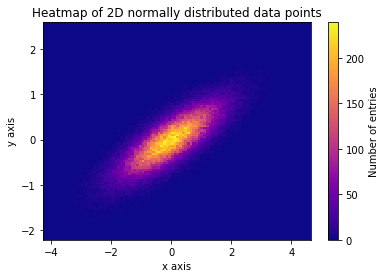

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define numbers of generated data points and bins per axis.
N_numbers = 100000
N_bins = 100

# set random seed 
np.random.seed(0)

# Generate 2D normally distributed numbers.
x, y = np.random.multivariate_normal(
        mean=[0.0, 0.0],      # mean
        cov=[[1.0, 0.4],
             [0.4, 0.25]],    # covariance matrix
        size=N_numbers
        ).T                   # transpose to get columns


# Construct 2D histogram from data using the 'plasma' colormap
plt.hist2d(x, y, bins=N_bins, cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of entries')

# Add title and labels to plot.
plt.title('Heatmap of 2D normally distributed data points')
plt.xlabel('x axis')
plt.ylabel('y axis')

# Show the plot.
plt.show()

In [12]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [14]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    approx = pm.fit()

Finished [100%]: Average Loss = 142.51


In [15]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

In [49]:
mu = pm.floatX([0.0, 0.0])
cov = pm.floatX([[1, 0.5], [0.5, 1.0]])
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.fit(method="fullrank_advi")

Finished [100%]: Average Loss = 0.012963


In [59]:
with pm.Model() as model:
    pm.MvNormal("x", mu=mu, cov=cov, shape=2)
    approx = pm.FullRankADVI(start=pm.Point(-5,5)).fit()

TypeError: can't turn [-5, 5] and {} into a dict. dict expected at most 1 argument, got 2

In [51]:
approx.sample?

In [52]:
trace

<MultiTrace: 1 chains, 1000 iterations, 1 variables>

In [53]:
trace['x']

array([[ 0.05143301, -1.26250418],
       [-0.51721788,  0.63523561],
       [-0.41773395,  0.54920961],
       ...,
       [ 2.18137372,  1.55117061],
       [-1.0625001 , -1.29447705],
       [ 1.20146113,  1.47595614]])

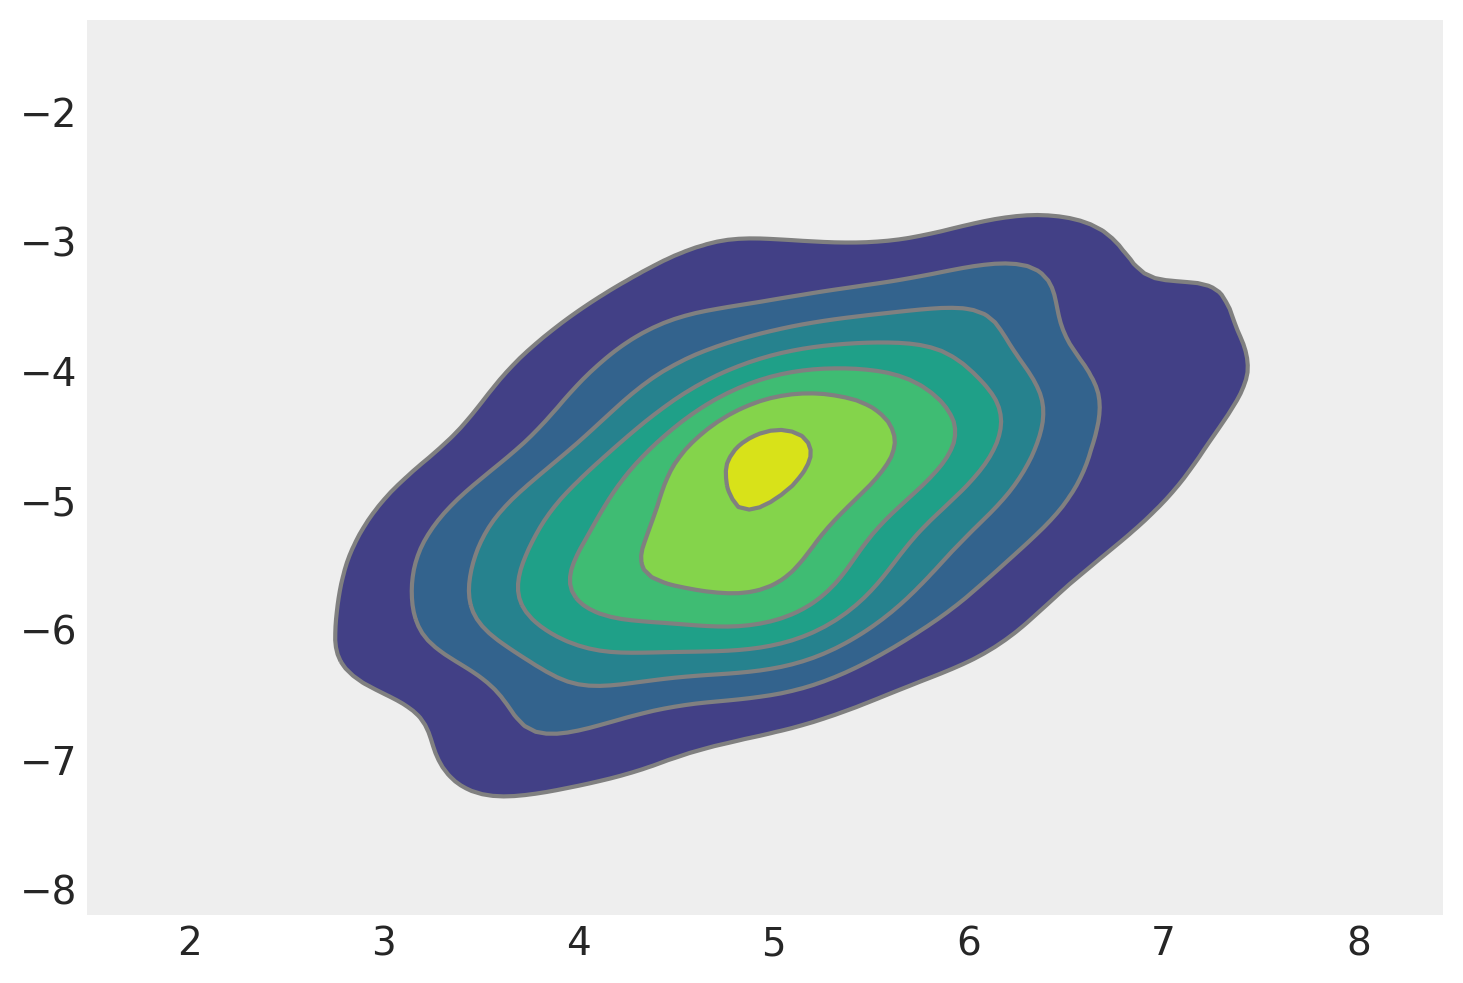

In [54]:
plt.figure()
trace = approx.sample(1000)
az.plot_kde(trace["x"][:, 0], trace["x"][:, 1]);

In [22]:
az.summary(trace, kind="stats")

Got error No model on context stack. trying to find log_likelihood in translation.
/home/mwm/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


ContextualVersionConflict: (scipy 1.6.2 (/home/mwm/anaconda3/lib/python3.8/site-packages), Requirement.parse('scipy<1.8.0,>=1.7.3'), {'pymc3'})

In [23]:
trace

<MultiTrace: 1 chains, 10000 iterations, 1 variables>

In [55]:
tmp = trace['x'][:100]

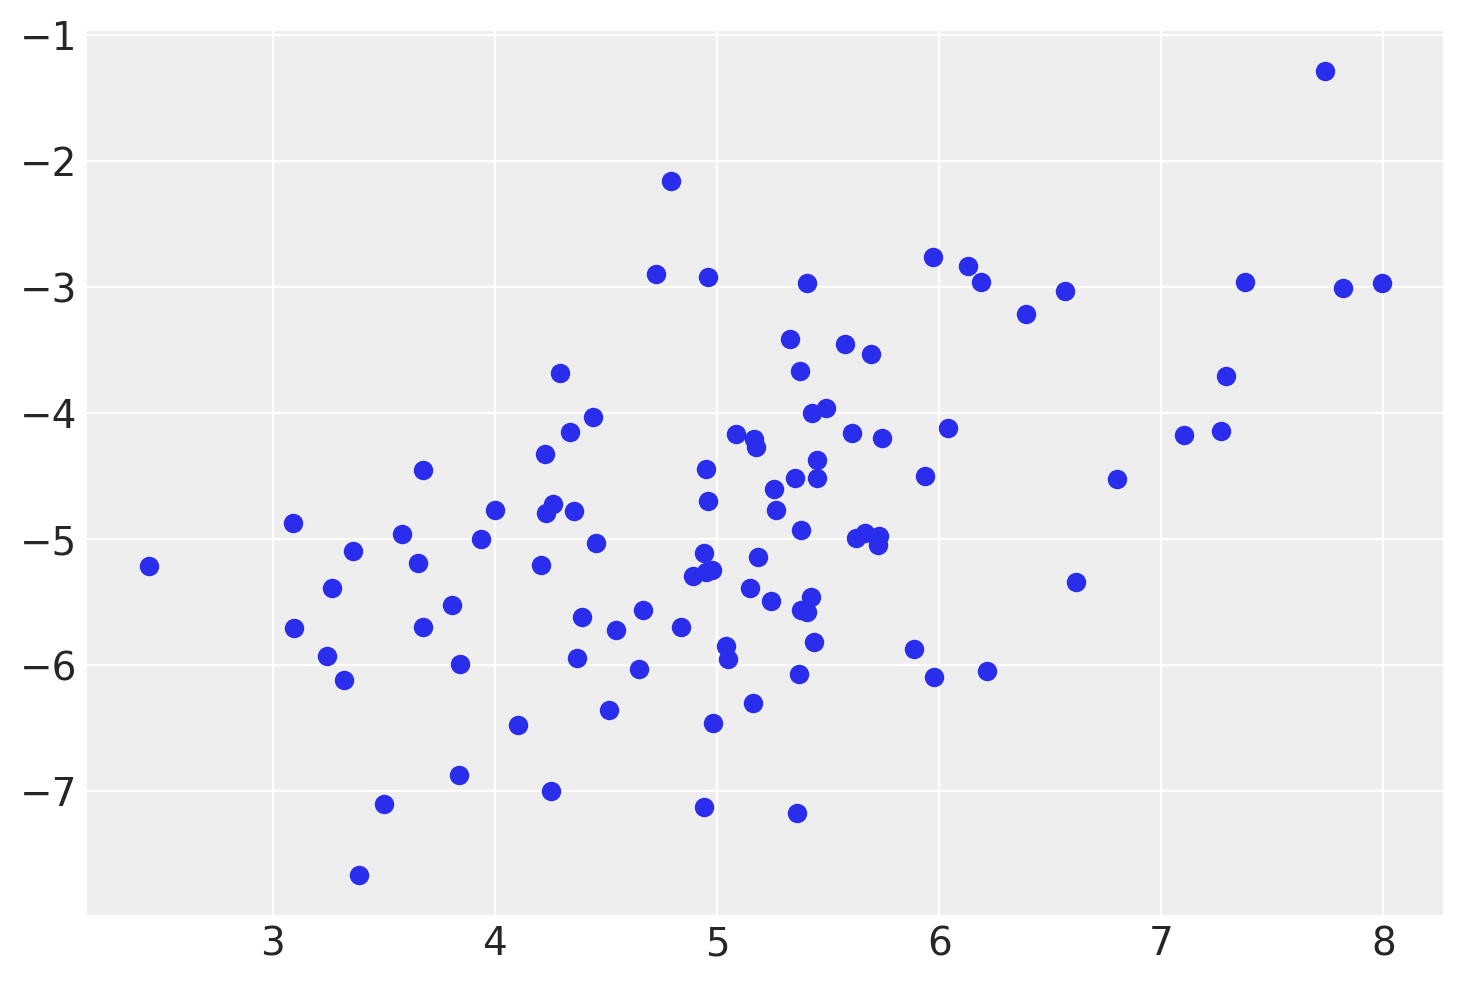

In [56]:
plt.scatter(x= tmp[:,0], y= tmp[:,1])

-0.10522854324809508

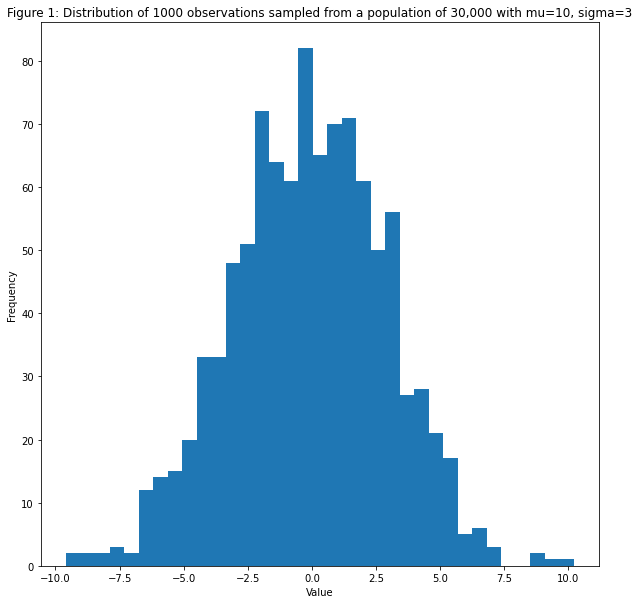

In [29]:
import numpy as np
import matplotlib.pyplot as plt
mod1=lambda t:np.random.normal(0,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")
mu_obs=observation.mean()
mu_obs

In [51]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))]

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    total = []
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        rule = (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new))))
        if rule:            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)    
        total.append((x_new[1], "." if rule else "x", "blue" if rule else "red"))
  
    return np.array(accepted), np.array(rejected), np.array(total)

In [52]:
accepted, rejected, total = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 500,observation,acceptance)


<ipython-input-51-87238d458e2e>:17: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))
<ipython-input-51-87238d458e2e>:52: RuntimeWarning: divide by zero encountered in log
  rule = (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new))))
<ipython-input-51-87238d458e2e>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(accepted), np.array(rejected), np.array(total)


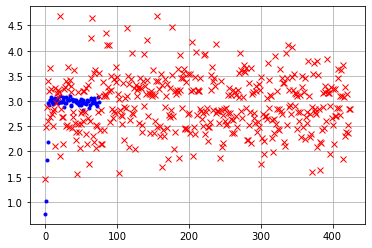

In [32]:
plt.plot(accepted[:,1], marker=".", color="blue",  linestyle = 'None',)
plt.plot(rejected[:,1], marker="x", color="red",  linestyle = 'None',)
plt.grid()

In [44]:
total

array([[array([-0.08206507]), '.', 'red'],
       [array([0.41531663]), '.', 'blue'],
       [array([0.33912754]), '.', 'red'],
       ...,
       [array([2.71970401]), '.', 'red'],
       [array([3.13631563]), '.', 'red'],
       [array([3.27771405]), '.', 'red']], dtype=object)

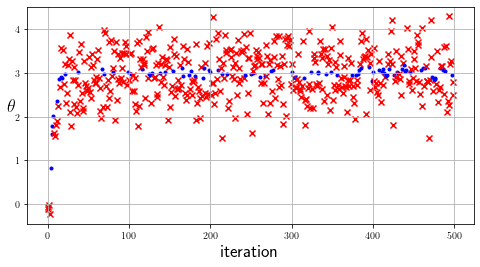

In [66]:

fig, axes = plt.subplots(1,1,figsize=(8,4))
for x,(y, m, c) in enumerate(total):
    axes.scatter(x=x,y=y,marker=m,color=c,  linestyle = 'None',)
axes.grid()
axes.set_ylabel(r"$\theta$", rotation=0, fontsize=18)
axes.set_xlabel("iteration", fontsize=18)
fig.savefig("../../chapter3/random_walk.png")

1.9459101490553132

In [34]:
accepted

array([[-0.10522854324809508, array([0.76197301])],
       [-0.10522854324809508, array([1.02240405])],
       [-0.10522854324809508, array([1.82809558])],
       [-0.10522854324809508, array([2.18816706])],
       [-0.10522854324809508, array([2.97123418])],
       [-0.10522854324809508, array([2.93210563])],
       [-0.10522854324809508, array([3.01476778])],
       [-0.10522854324809508, array([3.01986437])],
       [-0.10522854324809508, array([3.07271619])],
       [-0.10522854324809508, array([2.98538821])],
       [-0.10522854324809508, array([3.03611793])],
       [-0.10522854324809508, array([2.94743617])],
       [-0.10522854324809508, array([2.97170949])],
       [-0.10522854324809508, array([3.05426128])],
       [-0.10522854324809508, array([3.00578599])],
       [-0.10522854324809508, array([3.03041193])],
       [-0.10522854324809508, array([3.04321043])],
       [-0.10522854324809508, array([2.95961868])],
       [-0.10522854324809508, array([2.9596354])],
       [-0.10